# **Predicting Supreme Court Rulings with Deep Learning and Natural Language Processing**
Samuel Zorek

DTSA 5511 Final Project

# **Project Topic**
In this project, I implemented Long Short Term Memory (LSTM) deep learning for natural language processing to predict how the Supreme Court of the United States (SCOTUS) will rule on cases based purely on the wording of the petition that defines the legal question(s) that the court will here. After hyperparameter tuning, I was able to achieve a 74% accuracy, a somewhat surprisingly positive result in that this would have been before the court even heard oral arguments on a case.





# **Data**
After installing (as necessary since I did this project on Google Colab) and importing the relevatn libraries, I downloaded the data from the Supreme Court website (https://www.supremecourt.gov/orders/grantednotedlists.aspx). While I started doing the copying of each petition to the court manually, I found that the url had a pattern to it. More specifically, the url contained the docket number with 0 padding so that it would fit within a standard length. To that end, I wrote a script that iterates over an input file that contains a list of docket numbers and the result in numerical format. I did still have to type in that part manually, but it was less labor-intensive than also opening each pdf and copying the text. Another point to note was that I went back to petitions that were filed as far back as 2015.

In [ ]:
!pip install PyPDF2

In [ ]:
!pip install keras_tuner

In [ ]:
!pip install scikeras

In [ ]:
import requests
import urllib
from PyPDF2 import PdfFileMerger, PdfFileReader
import pandas as pd
import numpy as np
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from scipy import stats
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.preprocessing.sequence import pad_sequences
import re
import keras_tuner as kt
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
def download_pdf(url, file_name, headers):

    # Send GET request
    response = requests.get(url, headers=headers)

    # Save the PDF
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print(response.status_code)


if __name__ == "__main__":

    # Define HTTP Headers
    headers = {
        "User-Agent": "Chrome/51.0.2704.103",
    }

    # Define URL of a PDF
    url = "https://pyshark.com/wp-content/uploads/2022/05/merged_all_pages.pdf"

    # Define PDF file name
    file_name = "file1.pdf"

    # Download PDF
    download_pdf(url, file_name, headers)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from PyPDF2 import PdfReader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.listdir('/content/drive/My Drive/DTSA 5511/Final_Project'))

['14-1146.pdf', '14-1209.pdf', '14-1373.pdf', '14-1280.pdf', '14-1375.pdf', '14-1406.pdf', '14-1382.pdf', '15-191.pdf', '14-1457.pdf', '14-1507.pdf', '14-1504.pdf', '14-1520.pdf', '14-6166.pdf', '14-7505.pdf', '14-8349.pdf', '14-10154.pdf', '14-8358.pdf', '14-8913.pdf', '15-108.pdf', '15-138.pdf', '15-109.pdf', '15-145.pdf', '15-290.pdf', '15-255.pdf', '15-274.pdf', '15-338.pdf', '15-339.pdf', '15-375.pdf', '15-674.pdf', '15-415.pdf', '15-446.pdf', '15-420.pdf', '15-5040.pdf', '15-458.pdf', '15-5238.pdf', '15-6092.pdf', '12-1497.pdf', '13-271.pdf', '13-352.pdf', '13-433.pdf', '13-485.pdf', '13-435.pdf', '13-502.pdf', '13-550.pdf', '13-534.pdf', '13-517.pdf', '13-553.pdf', '13-684.pdf', '13-628.pdf', '13-719.pdf', '13-720.pdf', '13-894.pdf', '13-854.pdf', '13-896.pdf', '13-1138.pdf', '13-935.pdf', '13-975.pdf', '13-983.pdf', '13-1010.pdf', '13-1019.pdf', '13-1032.pdf', '13-1034.pdf', '13-1052.pdf', '13-1074.pdf', '13-1080.pdf', '13-1174.pdf', '13-1314.pdf', '13-1175.pdf', '13-1211.pdf',

In [ ]:

  # Define HTTP Headers
headers = {"User-Agent": "Chrome/51.0.2704.103"}

    # Define URL of a PDF
url = "https://www.supremecourt.gov/qp/06-00179qp.pdf"

    # Define PDF file name
file_name = "/content/drive/My Drive/DTSA 5511/Final_Project/file1.pdf"

    # Download PDF
download_pdf(url, file_name, headers)

In [ ]:
reader = PdfReader("/content/drive/My Drive/DTSA 5511/Final_Project/file1.pdf")
page = reader.pages[0]
print(page.extract_text())


06-179 RIEGEL V. MEDTRONIC, INC.
DECISION BELOW: 451 F3d 104
CERT. GRANTED 6/25/2007
QUESTION PRESENTED:
Whether the express preemption provision of the Medical Device Amendments to the 
Food, Drug, and Cosmetic Act, 21 U.S.C. §360k(a), preempts state-law claims 
seeking damages for injuries caused by medical devices that received premarket 
approval from the Food and Drug Administration. 
LOWER COURT CASE NUMBER: 04-0412



In [ ]:
case_number = "19-896"
p1, p2 = case_number.split("-")
print(p1)
print(p2)
len(p2)
if len(p2) == 2:
  part2 = "000" + p2
if len(p2) == 3:
  part2 = "00" + p2
if len(p2) == 4:
  part2 = "0" + p2


url = "https://www.supremecourt.gov/qp/" + p1 + "-" + part2 + "qp.pdf"
print(url)

file_name = "/content/drive/My Drive/DTSA 5511/Final_Project/" + case_number + ".pdf"
download_pdf(url, file_name, headers)
reader = PdfReader(file_name)
page = reader.pages[0]
print(page.extract_text())

19
896
https://www.supremecourt.gov/qp/19-00896qp.pdf
19-896 JOHNSON V. ARTEAGA-MARTINEZ
DECISION BELOW: 19-896 unreported
CERT. GRANTED 8/23/2021
QUESTION PRESENTED:
Whether an alien who is detained under 8 U.S.C. 1231 is entitled by statute, after six 
months of detention, to a bond hearing at which the government must prove to an 
immigration judge that the alien is a flight risk or a danger to the community.
LOWER COURT CASE NUMBER: 19-1054



In [ ]:
cases = pd.read_csv('/content/drive/My Drive/DTSA 5511/Final_Project/granted_cases_recent.csv')
#print(cases)
for c in range(len(cases)):
  #print(cases.loc[c,'Docket Number'])
  cn = cases.loc[c,'Docket Number']
  #print(cn)
  if isinstance(cn, float) == True:
    cases.drop(cases.tail(1).index,inplace=True)
    break
  p1, p2 = cn.split("-")
  if len(p2) == 2:
    part2 = "000" + p2
  if len(p2) == 3:
    part2 = "00" + p2
  if len(p2) == 4:
    part2 = "0" + p2
  if len(p2) == 5:
    part2 = p2

  url = "https://www.supremecourt.gov/qp/" + p1 + "-" + part2 + "qp.pdf"
  #print(url)

  file_name = "/content/drive/My Drive/DTSA 5511/Final_Project/" + cn + ".pdf"
  #download_pdf(url, file_name, headers) #already ran this line once
  reader = PdfReader(file_name)
  page = reader.pages[0]
  t = page.extract_text()
  cases.loc[c,'Text'] = t
  #print(t)

In [ ]:
print(cases)


     Docket Number  Result                                               Text
0           19-896     1.0  19-896 JOHNSON V. ARTEAGA-MARTINEZ\nDECISION B...
1          19-1392     1.0  19-1392 DOBBS V. JACKSON WOMEN'S HEALTH\nDECIS...
2          19-1401     2.0  19-1401 HUGHES V. NORTHWESTERN UNIVERSITY\nDEC...
3           20-219     0.0  20-219 CUMMINGS V. PREMIER REHAB KELLER, P.L.L...
4           20-303     1.0  20-303 UNITED STATES  V. VAELLO-MADERO\nDECISI...
...            ...     ...                                                ...
1075           NaN     NaN                                                NaN
1076           NaN     NaN                                                NaN
1077           NaN     NaN                                                NaN
1078           NaN     NaN                                                NaN
1079           NaN     NaN                                                NaN

[1080 rows x 3 columns]


# **Data Cleaning**
When I manually entered the outcomes of the cases, I used 0 for affirming, 1 for reversing, and 2 for all other results. Some of those other outcomes included affirmed in part/reversed in part and vacated and remanded. I just wanted to focus on affirm or reverse outcomes, so I filtered out all of the 2 result cases. There were also cases where the pdf petition text didn't read in properly. Rather than manually trying to fix each instance, I just deleted those rows. I then pre-processed the text using the methodology in Reference 9 to make the language simpler for a computer to process.

In [ ]:
cases = cases.dropna()
cases = cases.loc[cases['Result'] < 2]
print(cases)

    Docket Number  Result                                               Text
0          19-896     1.0  19-896 JOHNSON V. ARTEAGA-MARTINEZ\nDECISION B...
1         19-1392     1.0  19-1392 DOBBS V. JACKSON WOMEN'S HEALTH\nDECIS...
3          20-219     0.0  20-219 CUMMINGS V. PREMIER REHAB KELLER, P.L.L...
4          20-303     1.0  20-303 UNITED STATES  V. VAELLO-MADERO\nDECISI...
5          20-322     1.0  20-322 GARLAND V. GONZALEZ\nDECISION BELOW: 95...
..            ...     ...                                                ...
400        16-373     0.0  16-373 CA PUBLIC EMPLOYEES' RETIREMENT V. ANZ ...
401        16-399     1.0  16-399 PERRY V. MSPB\nDECISION BELOW: 829 F.3d...
402        16-405     1.0  16-405 BNSF RAILWAY CO. V. TYRRELL\nDECISION B...
403        16-466     1.0  16-466 BRISTOL-MYERS SQUIBB CO. V. SUPERIOR CO...
404        16-529     1.0  16-529 KOKESH V. SEC\nDECISION BELOW: 834 F.3d...

[301 rows x 3 columns]


In [ ]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

In [ ]:
cases['Text'] = cases['Text'].apply(lambda x: process(x))
print(cases)

    Docket Number  Result                                               Text
0          19-896     1.0  19 896 johnson v arteaga martinez decision bel...
1         19-1392     1.0  19 1392 dobbs v jackson women s health decisio...
3          20-219     0.0  20 219 cummings v premier rehab keller pllc de...
4          20-303     1.0  20 303 united states v vaello madero decision ...
5          20-322     1.0  20 322 garland v gonzalez decision below 955 f...
..            ...     ...                                                ...
400        16-373     0.0  16 373 ca public employees retirement v anz se...
401        16-399     1.0  16 399 perry v mspb decision below 829 f3d 760...
402        16-405     1.0  16 405 bnsf railway co v tyrrell decision belo...
403        16-466     1.0  16 466 bristol myers squibb co v superior cour...
404        16-529     1.0  16 529 kokesh v sec decision below 834 f3d 115...

[301 rows x 3 columns]


# **Exploratory Data Analysis**
My first part of the exploratory data analysis was to plot the affirmed vs. reversed case counts. I found that there were more cases reversed than affirmed. This does make some intuitive sense in that if SCOTUS agrees to hear a case, it is because they believe there is some aspect of the legal reasoning of the lower court that may need to be clarified. If a case is clearly decided correctly, SCOTUS would refuse to hear the case, which is what they do the for the vast majority of petitions received. Therefore, if they do hear a case, there is a decent (>50%) chance that they will reverse the lower court's ruling.

The second part of my exploratory data analysis was to produce a word cloud that covers the most common words used across all petitions. In addition to the boilerplate language used across all of the case petitions, I could see features that I hypothesized would be relevant for the algorithm to consider. For example, the "ninth circuit" was one of the words. The Ninth Circuit is based in California and is known for often having differences in jurisprudence from the current composition of the Supreme Court. Therefore, it wouldn't surprise me if Ninth Circuit opinions were overturned at a higher rate than other circuit courts. The term "religious" was also in the word cloud. Over the last few years, the Supreme Court has heard multiple religious liberty cases. I would expect that if a case relates to religion, it likely has a similar outcome compared to other cases of the same topic.

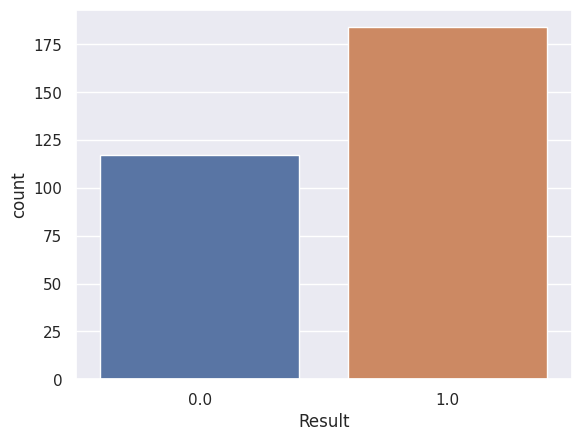

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Result", data=cases)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

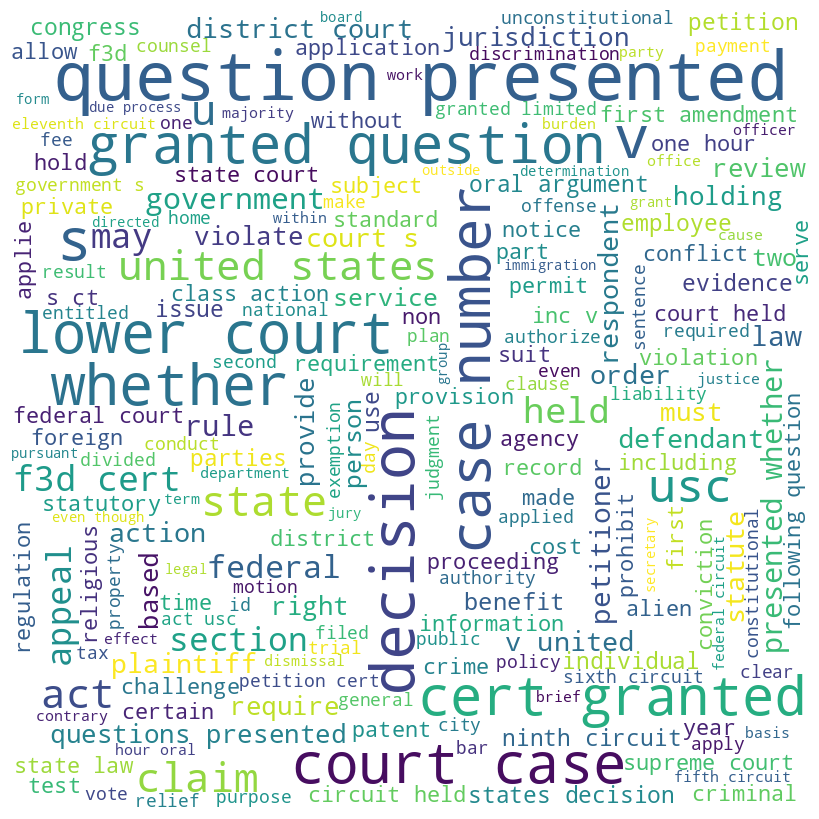

In [ ]:
df = ' '.join(cases['Text'])
#print(df)
comment_words = ''
stopwords = set(STOPWORDS)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# **Model Construction**
I implemented LSTM with a dropout layer and sigmoid activation to model and capture any patterns in the word data input. I followed parts of the methodology in Reference 9.

My first step was to separate the data into training and testing cases.

Since the raw text was not yet in a good format for model training, I used the tokenizer library with a language dictionary size of 5,000 words to convert the word counts into sequences that could be ingested into the deep learning model.

Because there was an imbalance in the data, a potential concern I deliberately sought to address was whether the model would just learn to assume all cases are reversed since the majority of them are so. In the validation data set, 60% of cases were reversed. Therefore, even a 60% accuracy score wouldn't be better than just guessing everything was reversed. When I was developing the models, I actually found some cases where the model would always predict "reverse." I corrected that by tuning the learning rate parameter. If the learning rate was too high, it would memorize cases. If it was too low, it would get stuck on the obvious logic that more cases are reversed than affirmed and do nothing more. I found 0.0005 was a good balance. That is slightly lower than the default learning rate in Keras/Tensor Flow.

I picked a batch size of 1 because I didn't have much data to train the model on. If I had more cases, I would increase the batch size.

For further model refinement, I conducted a hyperparameter tuning experiment. I specifically tested how varying the dropout rate impacted the acccuracy of the validation tests. I found that a dropout rate of 0.2 yielded the best outcome.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(cases['Text'], cases['Result'], test_size=.2, random_state=42)

In [ ]:
dict_size = 5000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(cases['Text'])

In [ ]:
train_rev_tokens = tokenizer.texts_to_sequences(train_x)
test_rev_tokens = tokenizer.texts_to_sequences(test_x)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

In [ ]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

In [ ]:
output_dim = 14
units_lstm = 16

# **Results and Analysis**
The validation accuracies of all of the models were higher than the underlying case reversal rate of 60%. This suggests that the models were doing better than a 'guess.' The dropout rate of 0.2 performed the best, with an accuracy on the unseen validation dataset of 74%.

I produced confusion matrices for all of the validation test results because I wanted to see whether they were biased towards just reversing all of the cases as a default. There was that bias in the 0.1 dropout rate, but the others were ok in that respect.

**Dropout Rate = 0.1**

Epoch 1/5
240/240 [==============================] - 22s 77ms/step - loss: 0.6818 - accuracy: 0.6042
Epoch 2/5
240/240 [==============================] - 3s 14ms/step - loss: 0.6620 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 3s 12ms/step - loss: 0.6011 - accuracy: 0.6667
Epoch 4/5
240/240 [==============================] - 3s 11ms/step - loss: 0.3585 - accuracy: 0.9333
Epoch 5/5
2/2 [==============================] - 0s 12ms/step


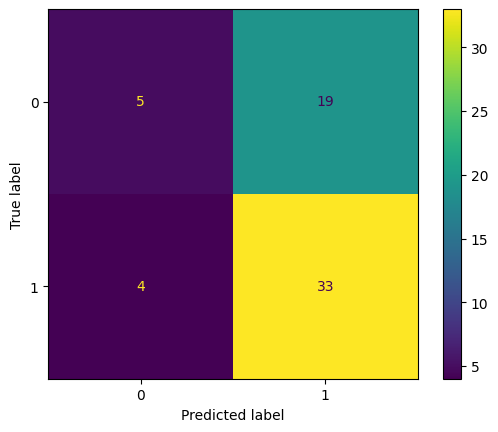

In [ ]:
r = 0.1

model1 = Sequential()
model1.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model1.add(LSTM(units_lstm))
model1.add(Dropout(r))
model1.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model1.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted1 = model1.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model1.evaluate(test_rev_pad, test_y)
predictions = np.round(model1.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate = 0.2**

Epoch 1/5
240/240 [==============================] - 37s 146ms/step - loss: 0.6867 - accuracy: 0.5750
Epoch 2/5
240/240 [==============================] - 9s 36ms/step - loss: 0.6607 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 7s 28ms/step - loss: 0.5804 - accuracy: 0.6250
Epoch 4/5
240/240 [==============================] - 4s 18ms/step - loss: 0.3469 - accuracy: 0.9292
Epoch 5/5
2/2 [==============================] - 1s 14ms/step


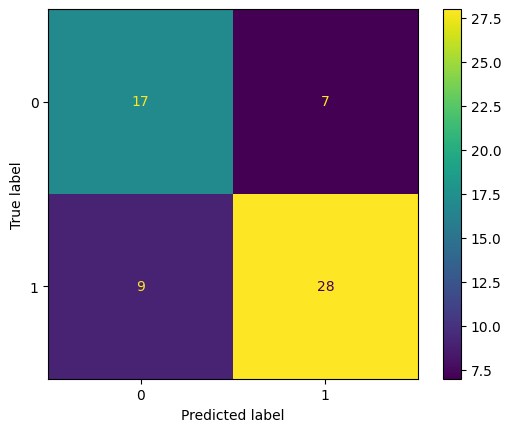

In [ ]:

r = 0.2

model2 = Sequential()
model2.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model2.add(LSTM(units_lstm))
model2.add(Dropout(r))
model2.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model2.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted2 = model2.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model2.evaluate(test_rev_pad, test_y)
predictions = np.round(model2.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.3***

Epoch 1/5
240/240 [==============================] - 33s 117ms/step - loss: 0.6846 - accuracy: 0.6042
Epoch 2/5
240/240 [==============================] - 8s 33ms/step - loss: 0.6603 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 4s 17ms/step - loss: 0.5667 - accuracy: 0.7542
Epoch 4/5
240/240 [==============================] - 3s 12ms/step - loss: 0.3720 - accuracy: 0.9458
Epoch 5/5
2/2 [==============================] - 0s 12ms/step


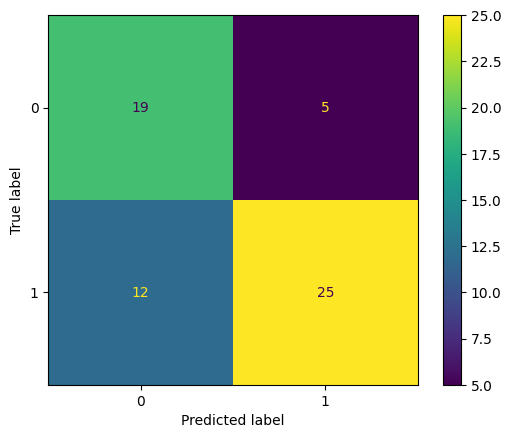

In [ ]:

r = 0.3

model3 = Sequential()
model3.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model3.add(LSTM(units_lstm))
model3.add(Dropout(r))
model3.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model3.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted3 = model3.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model3.evaluate(test_rev_pad, test_y)
predictions = np.round(model3.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.4**

Epoch 1/5
240/240 [==============================] - 18s 68ms/step - loss: 0.6887 - accuracy: 0.5792
Epoch 2/5
240/240 [==============================] - 3s 12ms/step - loss: 0.6759 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 4s 17ms/step - loss: 0.6640 - accuracy: 0.6333
Epoch 4/5
240/240 [==============================] - 4s 16ms/step - loss: 0.5490 - accuracy: 0.8250
Epoch 5/5
2/2 [==============================] - 0s 13ms/step


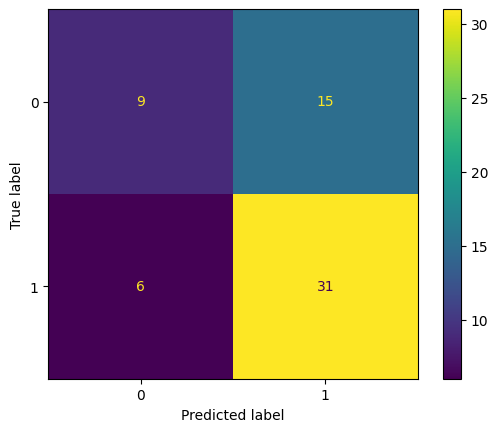

In [ ]:
r = 0.4

model4 = Sequential()
model4.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model4.add(LSTM(units_lstm))
model4.add(Dropout(r))
model4.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model4.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted4 = model4.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model4.evaluate(test_rev_pad, test_y)
predictions = np.round(model4.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.5**

Epoch 1/5
240/240 [==============================] - 18s 69ms/step - loss: 0.6877 - accuracy: 0.5833
Epoch 2/5
240/240 [==============================] - 3s 13ms/step - loss: 0.6764 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 4s 16ms/step - loss: 0.6452 - accuracy: 0.6125
Epoch 4/5
240/240 [==============================] - 3s 14ms/step - loss: 0.4959 - accuracy: 0.8500
Epoch 5/5
2/2 [==============================] - 0s 10ms/step


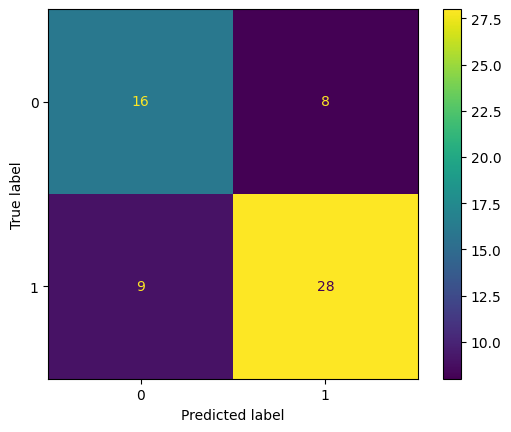

In [ ]:
r = 0.5

model5 = Sequential()
model5.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model5.add(LSTM(units_lstm))
model5.add(Dropout(r))
model5.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model5.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted4 = model5.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model5.evaluate(test_rev_pad, test_y)
predictions = np.round(model5.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.6**

Epoch 1/5
240/240 [==============================] - 19s 69ms/step - loss: 0.6844 - accuracy: 0.5917
Epoch 2/5
240/240 [==============================] - 4s 17ms/step - loss: 0.6708 - accuracy: 0.6125
Epoch 3/5
240/240 [==============================] - 8s 32ms/step - loss: 0.6455 - accuracy: 0.6250
Epoch 4/5
240/240 [==============================] - 9s 36ms/step - loss: 0.4933 - accuracy: 0.8458
Epoch 5/5
2/2 [==============================] - 1s 15ms/step


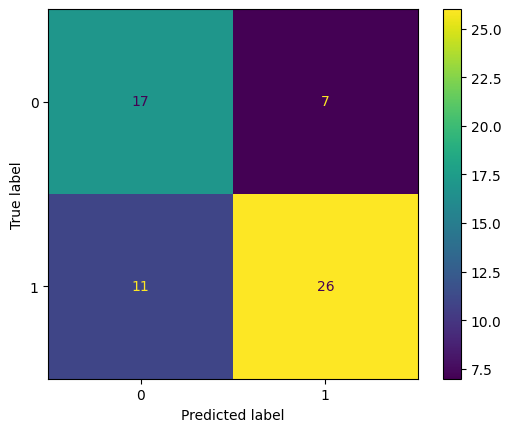

In [ ]:
r = 0.6

model6 = Sequential()
model6.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model6.add(LSTM(units_lstm))
model6.add(Dropout(r))
model6.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 5

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model6.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted6 = model6.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model6.evaluate(test_rev_pad, test_y)
predictions = np.round(model6.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.7**

Epoch 1/7
240/240 [==============================] - 19s 71ms/step - loss: 0.6898 - accuracy: 0.5750
Epoch 2/7
240/240 [==============================] - 3s 12ms/step - loss: 0.6740 - accuracy: 0.6083
Epoch 3/7
240/240 [==============================] - 3s 12ms/step - loss: 0.6432 - accuracy: 0.6125
Epoch 4/7
240/240 [==============================] - 4s 17ms/step - loss: 0.5424 - accuracy: 0.7542
Epoch 5/7
240/240 [==============================] - 4s 16ms/step - loss: 0.3710 - accuracy: 0.9542
Epoch 6/7
240/240 [==============================] - 3s 12ms/step - loss: 0.2429 - accuracy: 0.9750
Epoch 7/7
2/2 [==============================] - 1s 14ms/step


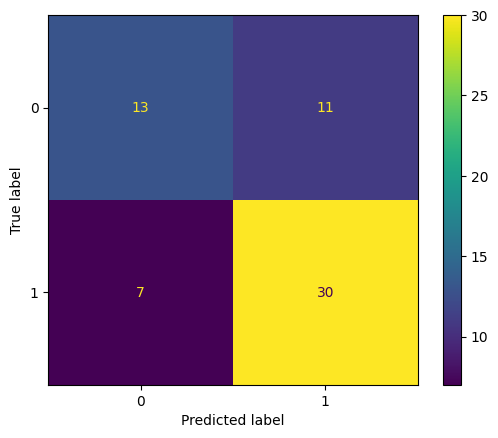

In [ ]:
r = 0.7

model7 = Sequential()
model7.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model7.add(LSTM(units_lstm))
model7.add(Dropout(r))
model7.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 7

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model7.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted7 = model7.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model7.evaluate(test_rev_pad, test_y)
predictions = np.round(model7.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.8**

Epoch 1/7
240/240 [==============================] - 24s 83ms/step - loss: 0.6916 - accuracy: 0.5333
Epoch 2/7
240/240 [==============================] - 6s 24ms/step - loss: 0.6837 - accuracy: 0.6125
Epoch 3/7
240/240 [==============================] - 5s 22ms/step - loss: 0.6720 - accuracy: 0.6167
Epoch 4/7
240/240 [==============================] - 5s 23ms/step - loss: 0.6464 - accuracy: 0.6042
Epoch 5/7
240/240 [==============================] - 5s 22ms/step - loss: 0.5790 - accuracy: 0.7250
Epoch 6/7
240/240 [==============================] - 5s 21ms/step - loss: 0.4355 - accuracy: 0.8583
Epoch 7/7
2/2 [==============================] - 0s 11ms/step


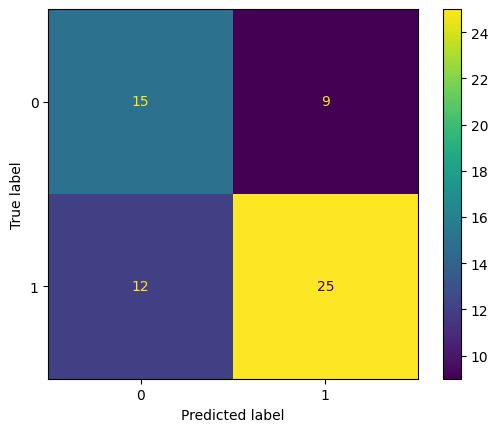

In [ ]:
r = 0.8

model8 = Sequential()
model8.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model8.add(LSTM(units_lstm))
model8.add(Dropout(r))
model8.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 7

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model8.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted8 = model8.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model8.evaluate(test_rev_pad, test_y)
predictions = np.round(model8.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

**Dropout Rate 0.9**

Epoch 1/7
240/240 [==============================] - 24s 85ms/step - loss: 0.6919 - accuracy: 0.5583
Epoch 2/7
240/240 [==============================] - 3s 14ms/step - loss: 0.6805 - accuracy: 0.6083
Epoch 3/7
240/240 [==============================] - 3s 12ms/step - loss: 0.6717 - accuracy: 0.6125
Epoch 4/7
240/240 [==============================] - 3s 14ms/step - loss: 0.6541 - accuracy: 0.5958
Epoch 5/7
240/240 [==============================] - 4s 17ms/step - loss: 0.6273 - accuracy: 0.6500
Epoch 6/7
240/240 [==============================] - 3s 13ms/step - loss: 0.5496 - accuracy: 0.7000
Epoch 7/7
2/2 [==============================] - 0s 11ms/step


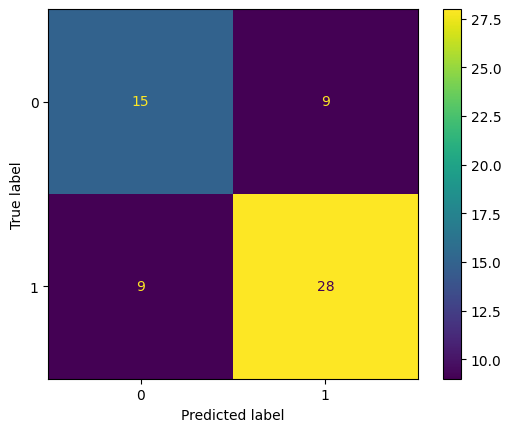

In [ ]:
r = 0.9

model9 = Sequential()
model9.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model9.add(LSTM(units_lstm))
model9.add(Dropout(r))
model9.add(Dense(1, activation='sigmoid'))

validation_split = 0
batch_size = 1
epochs = 7

opt = keras.optimizers.Adam(learning_rate=0.0005) #really trying to slow down the learning rate
#model2.compile(optimizer='adam', loss='bce', metrics='accuracy')
model9.compile(optimizer=opt, loss='bce', metrics='accuracy')
fitted9 = model9.fit(train_rev_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

test_pred =  model9.evaluate(test_rev_pad, test_y)
predictions = np.round(model9.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_y, predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()

In [ ]:
model_final = model2

# **Discussion and Conclusion**

In this project, I implemented natural language processing with a Long Short Term Memory Deep Learning model to predict how the Supreme Court will rule on a case based purely on the question wording in a granted petition. With my best model, I achieved a 74% accuracy rate! I was very pleased with this result, which was above the 60% accuracy that could have been achieved by guessing that all cases are reversed. This suggests to me that there are patterns and keywords in the petition that give some clues (not deterministically) about how SCOTUS will decide on an issue.

One observation I made during my work was the effect of including smaller or wider datasets. In this final version of the project, I included several years worth of cases. In my original version of the project, I included as many cases as I could find. This went back more than 20 years. The models performed worse when the dataset included court compositions vastly different from the current or recent courts. I think this means that while my model was looking at how SCOTUS as a whole ruled, the court now is so vastly different from the court in 2005 that the same model cannot beat the baseline reversal rate when trained and tested on a mix of cases spanning such a large time span.

If I were to continue this project further, I would want to include the transcript of the oral arguments and see how a model might be able to guess how a case will be decided based on the oral arguments. I would also like to break down predictions for specific justices. Another idea would be to try to predict how lower courts, which hear more cases, might make a ruling. The final dataset I used in this project with less than 1,000 cases likely didn't constitute 'big data.'

Overall, I was pleased with the outcome of my project.

**References**

https://stackoverflow.com/questions/9751197/opening-pdf-urls-with-pypdf
https://stackoverflow.com/questions/27387415/how-would-i-get-everything-before-a-in-a-string-python
https://stackoverflow.com/questions/24844729/download-pdf-using-urllib
https://www.supremecourt.gov/orders/grantednotedlists.aspx
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
https://keras.io/api/optimizers/
https://stats.stackexchange.com/questions/266368/deep-learning-why-does-increase-batch-size-cause-overfitting-and-how-does-one-r
https://www.geeksforgeeks.org/generating-word-cloud-python/
https://keras.io/examples/nlp/multi_label_classification/
https://github.com/keras-team/keras/blob/master/keras/datasets/imdb.py
https://stackoverflow.com/questions/49146529/how-keras-imdb-dataset-data-is-preprocessed#:~:text=The%20words%20in%20the%20imdb,it%20will%20download%20the%20dataset.&text=numpy%20arrays%20x_train%2C%20y_train%2C%20x_test,returned%20by%20the%20load_data%20function.
https://keras.io/examples/nlp/bidirectional_lstm_imdb/
https://www.kaggle.com/code/rafaeltiedra/step-by-step-imdb-sentiment-analysis
Used this notebook from a different context/application for the text pre-processing and model structure logic

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
https://datascience.stackexchange.com/questions/32194/how-to-predict-class-label-from-class-probability-given-by-predict-generator-for
https://keras.io/api/layers/regularization_layers/dropout/
https://github.com/sjzorek/dtsa5511week4 Used parts of my own code from the week 4 assignment in this class
https://scholar.smu.edu/datasciencereview/vol7/iss1/4/